In [1]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
import os
import pickle

import random

from mingpt.model import GPT
from model import setup_configs
from config import Detection
from utils import pickle_model


import matplotlib.pyplot as plt

Creating data points ...


In [2]:
class MetaNetwork(nn.Module):
    def __init__(self, num_queries, num_classes=1):
        super().__init__()
        input_size = 28 * 42 * num_queries

        print(f"query size (input): {input_size}")

        self.queries = nn.Parameter(torch.rand(num_queries, 28, 128))

        self.affines = nn.Linear(input_size, 2048)
        self.norm1 = nn.LayerNorm(2048)
        self.relu1 = nn.ReLU(True)

        self.dropout = nn.Dropout(0.5)

        self.lin2 = nn.Linear(2048, 512)
        self.norm2 = nn.LayerNorm(512)
        self.relu2 = nn.ReLU(True)

        self.dropout2 = nn.Dropout(0.5)

        self.lin3 = nn.Linear(512, 128)
        self.norm3 = nn.LayerNorm(128)
        self.relu3 = nn.ReLU(True)

        self.final_output = nn.Linear(128, num_classes)
    
    def forward(self, net):
        """
        :param net: an input network of one of the model_types specified at init
        :param data_source: the name of the data source
        :returns: a score for whether the network is a Trojan or not
        """
        query = self.queries
        out, _ = net(embeded=query)

        out = out.view(1, -1)

        out = self.affines(out)
        out = self.norm1(out)
        out = self.relu1(out)

        out = self.dropout(out)

        out = self.lin2(out)
        out = self.norm2(out)
        out = self.relu2(out)

        out = self.dropout2(out)

        out = self.lin3(out)
        out = self.norm3(out)
        out = self.relu3(out)

        return self.final_output(out)


In [3]:
def load_models(path: str, train_partition: float = 0.7) -> tuple[tuple[nn.Module, int], tuple[nn.Module, int]]: 
    train = []
    test = []

    test_clean_count = 0
    train_clean_count = 0

    failed = []
    with os.scandir(path) as files:
        for file in files: 
            try:
                with open(file.path, 'rb') as f:
                    checkpoint = pickle.load(f)
                    model_config, _ = setup_configs()
                    model = GPT(model_config)
                    model.load_state_dict(checkpoint)
                item = (
                    model,
                    0 if file.name.startswith("clean") else 1
                )
                if np.random.rand() < train_partition: 
                    train.append(item)
                    train_clean_count += file.name.startswith("clean")
                else: 
                    test.append(item)
                    test_clean_count += file.name.startswith("clean")
            except Exception:
                # print(f"corrupted pickle: {file.name}")
                failed.append(file.name)

    # test = np.random.permutation(test)
    # train = np.random.permutation(train)

    random.shuffle(train)
    random.shuffle(test)
    total = len(train) + len(test)
    total_clean = test_clean_count + train_clean_count


    print(f"Global partition: \n\t Total: {total} \n\tClean: {100*total_clean/total:.2f} \n\tTrojan: {100*(1 - total_clean/total):.2f}")
    print(f"Train partition: \n\tClean: {100 * train_clean_count / len(train):.2f}% \n\tTrojan: {100 * (1 - train_clean_count / len(train)) :.2f}%")
    print(f"Test partition: \n\tClean: {100 * test_clean_count / len(test):.2f}% \n\tTrojan: {100 * (1 - test_clean_count / len(test)) :.2f}%")


    if failed:
        with open("corrupted.sh", "w") as f:
            f.write("rm -f" + " ".join(failed))

    return train, test


In [4]:
def test_MNTD(model: nn.Module, data_models: tuple[nn.Module, int]) -> None:
    model.eval()
    loss_ema = np.inf
    loss = 0
    total = 0
    correct = 0

    for i, (net, label) in enumerate(data_models):
        net.eval()
        out = model(net)
        loss = F.binary_cross_entropy_with_logits(out, torch.FloatTensor([label]).unsqueeze(0))
        # loss.backward(inputs=list(model.parameters()))
        # model.queries.data = model.queries.data.clamp(0, 1)
        loss_ema = loss.item() if loss_ema == np.inf else 0.95 * loss_ema + 0.05 * loss.item()
        loss += loss_ema
        loss += sum(Detection.LAMBDA_L1 * torch.norm(parameter, 1) for parameter in model.parameters()) ## L1 regularization
        
        # print(out.item(), label)
        correct += (out.item() - 1/2) * (label - 1/2) > 0
        total += 1

    print(f"loss {loss}")
    print(f"acuracy: {correct/total:.5f}")
    return loss, correct/total

In [5]:
def train_MNTD(model: nn.Module, data_models: tuple[nn.Module, int], validation_split: float = 0.3) -> None:
    print("training model\n\n")

    random.shuffle(data_models)
    partition_point = int(len(data_models)*validation_split)
    validation_data_models = data_models[:partition_point]
    train_data_models = data_models[partition_point:]

    print(f"Train partition: {len(train_data_models)}")
    print(f"Validation partition: {len(validation_data_models)}")

    model.train()
    num_epochs = Detection.NUM_EPOCHS
    lr = Detection.LEARNING_RATE
    weight_decay = Detection.WEIGHT_DECAY
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs * len(train_data_models))

    loss_ema = np.inf

    test_losses = []
    train_losses = []
    test_accuracies = []

    best_model = None
    best_model_loss = float('inf')
    best_model_accuracy = 0


    try:
        for epoch in range(num_epochs):
            epoch_loss = 0 

            model.train()
            for i, (net, label) in enumerate(train_data_models):
                net.eval()

                out = model(net)

                loss = F.binary_cross_entropy_with_logits(out, torch.FloatTensor([label]).unsqueeze(0))
                loss += sum(Detection.LAMBDA_L1 * torch.norm(parameter, 1) for parameter in model.parameters()) ## L1 regularization

                optimizer.zero_grad()
                loss.backward(inputs=list(model.parameters()))
                optimizer.step()
                scheduler.step()
                model.queries.data = model.queries.data.clamp(0, 1)
                loss_ema = loss.item() if loss_ema == np.inf else 0.95 * loss_ema + 0.05 * loss.item()
                epoch_loss += loss_ema

            print("\nValidation batch:")
            test_loss, test_acc = test_MNTD(model, validation_data_models)
            test_losses.append(test_loss.item())
            test_accuracies.append(test_acc)
            train_losses.append(epoch_loss)

            print(f"train batch: epoch {epoch} - loss {epoch_loss}")

            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
            ax1.plot(test_losses)
            ax1.set_title('Test losses')

            ax2.plot(train_losses)
            ax2.set_title('Train losses')

            ax3.plot(test_accuracies)
            ax3.set_title('Test Accuracy')

            plt.show()

            # saving best result from loss measure
            # if test_loss < best_model_loss:
            #     best_model_loss = test_loss
            #     best_model = model.state_dict()

            # saving best result from accuracy measure
            if test_acc > best_model_accuracy:
                best_model_accuracy = test_acc
                best_model = model.state_dict()

    finally:
        return test_losses, test_accuracies, train_losses, best_model

In [6]:
train, test = load_models("/run/media/guilherme.vieira-manhaes/UBUNTU 22_1/psc/finals", .7)

query size (input): 11760
training model


Train partition: 2168
Validation partition: 240

Validation batch:
loss 3.700751781463623
acuracy: 0.49583
train batch: epoch 0 - loss 12179.859976418984


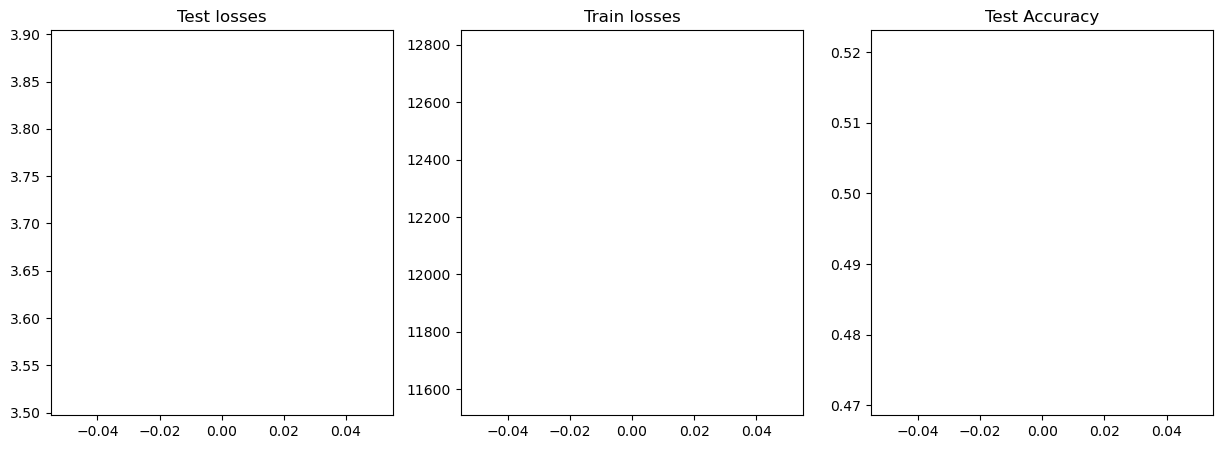


Validation batch:
loss 2.869941473007202
acuracy: 0.53333
train batch: epoch 1 - loss 6089.7492149537275


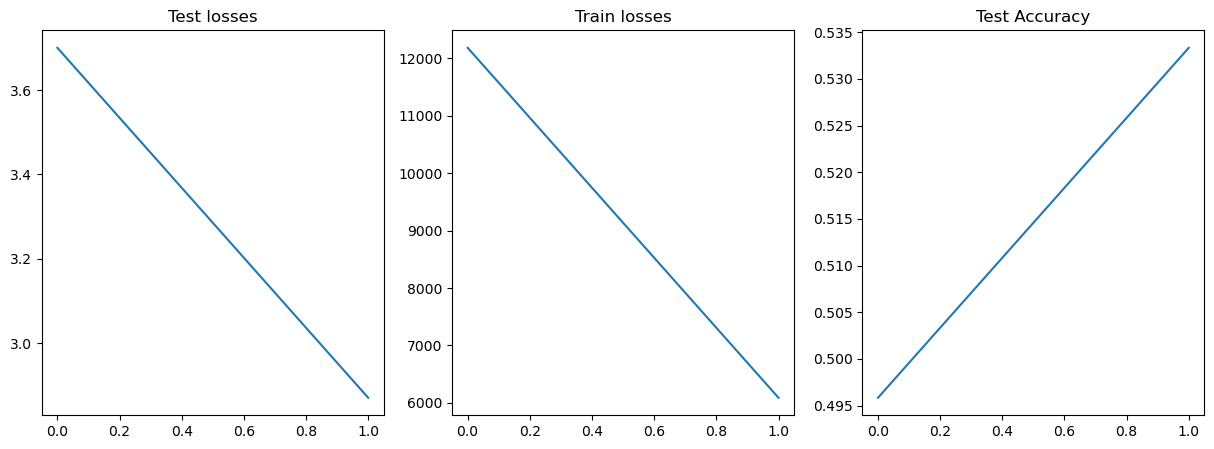


Validation batch:
loss 2.5725021362304688
acuracy: 0.65417
train batch: epoch 2 - loss 5142.968025447339


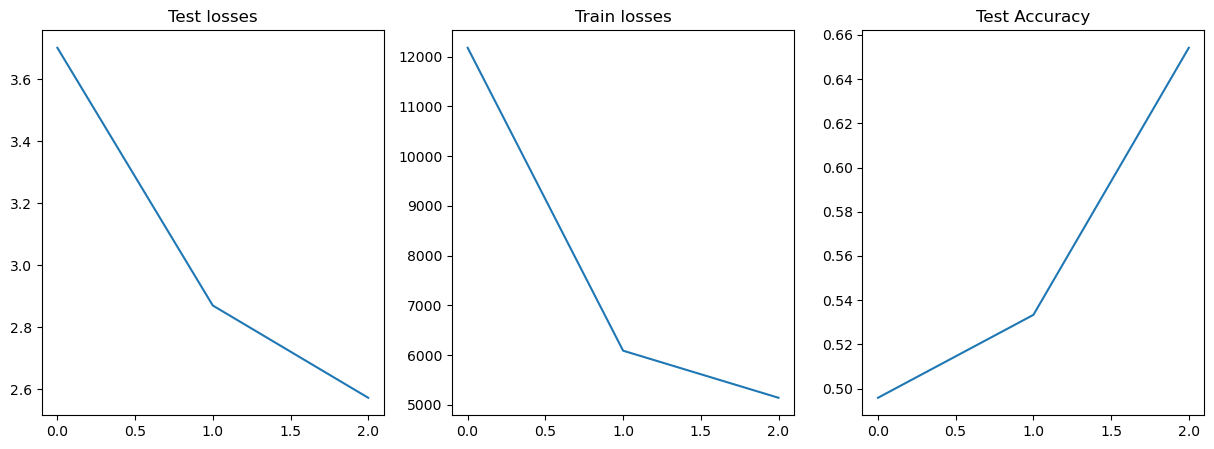


Validation batch:
loss 2.3663241863250732
acuracy: 0.65000
train batch: epoch 3 - loss 4684.329948752613


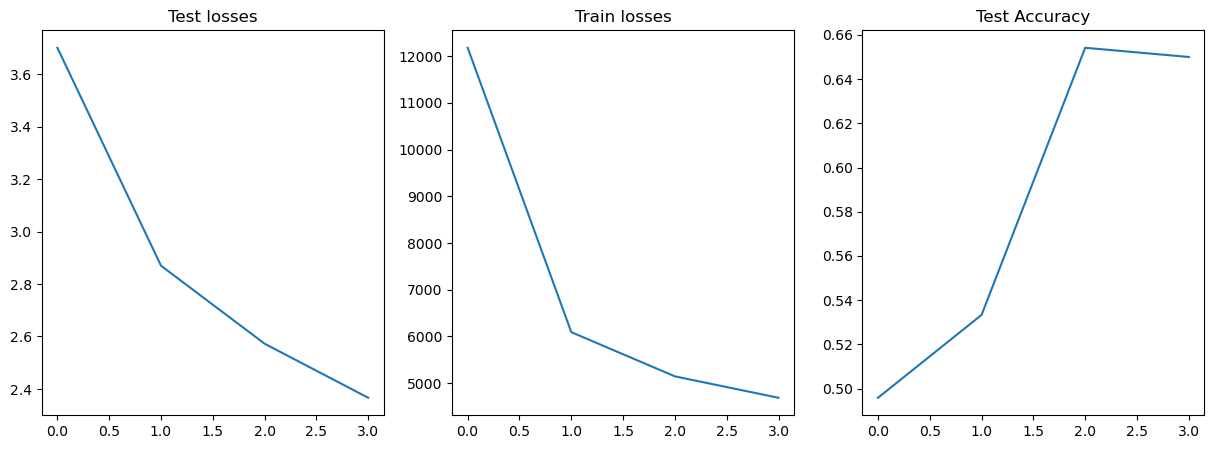


Validation batch:
loss 2.1919565200805664
acuracy: 0.70417
train batch: epoch 4 - loss 4400.386087847477


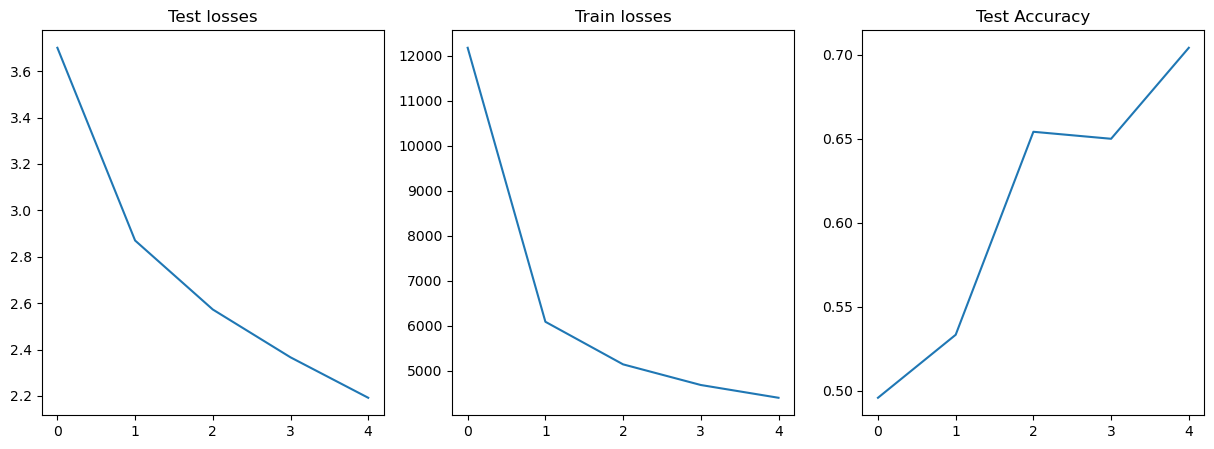


Validation batch:
loss 2.056149482727051
acuracy: 0.67917
train batch: epoch 5 - loss 4152.916414911176


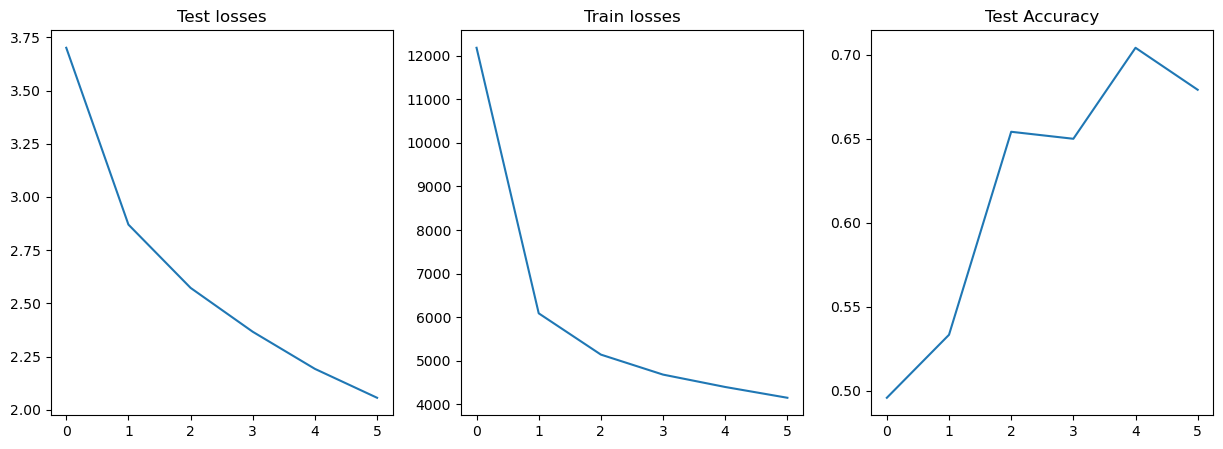


Validation batch:
loss 2.0851662158966064
acuracy: 0.71667
train batch: epoch 6 - loss 3965.4901917852185


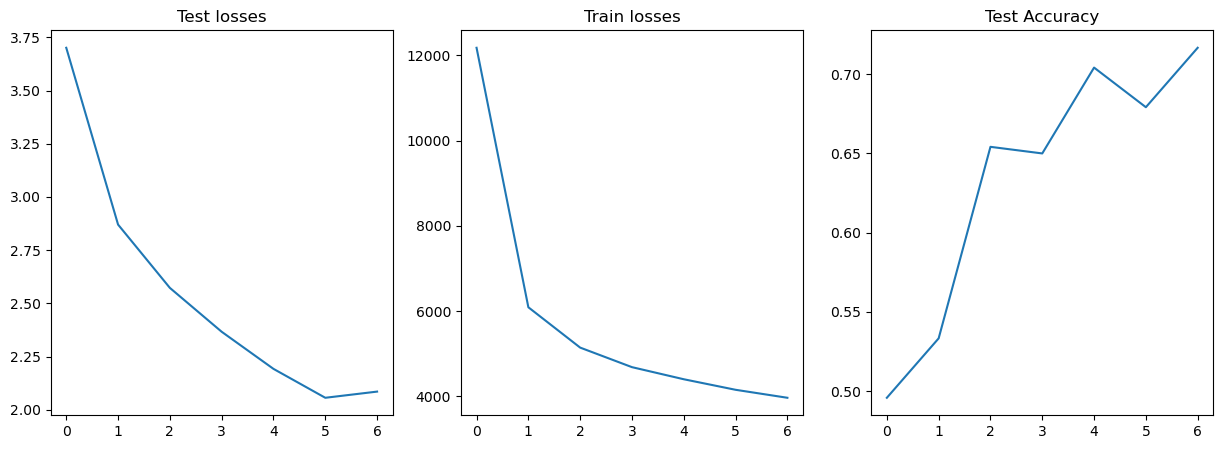


Validation batch:
loss 2.0196166038513184
acuracy: 0.70833
train batch: epoch 7 - loss 3845.1831772737405


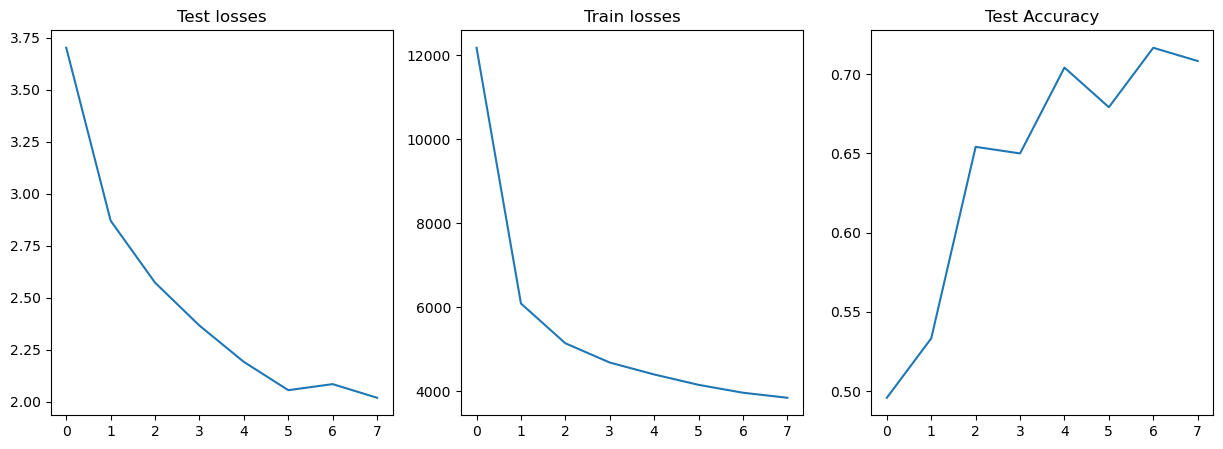


Validation batch:
loss 1.9252712726593018
acuracy: 0.71250
train batch: epoch 8 - loss 3743.713178780923


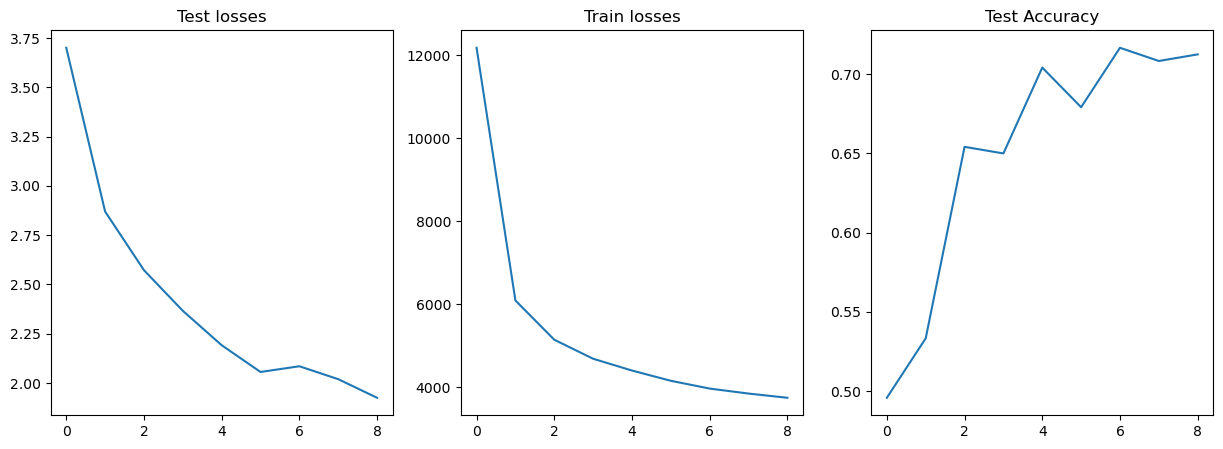


Validation batch:
loss 1.8960065841674805
acuracy: 0.73750
train batch: epoch 9 - loss 3631.436321105168


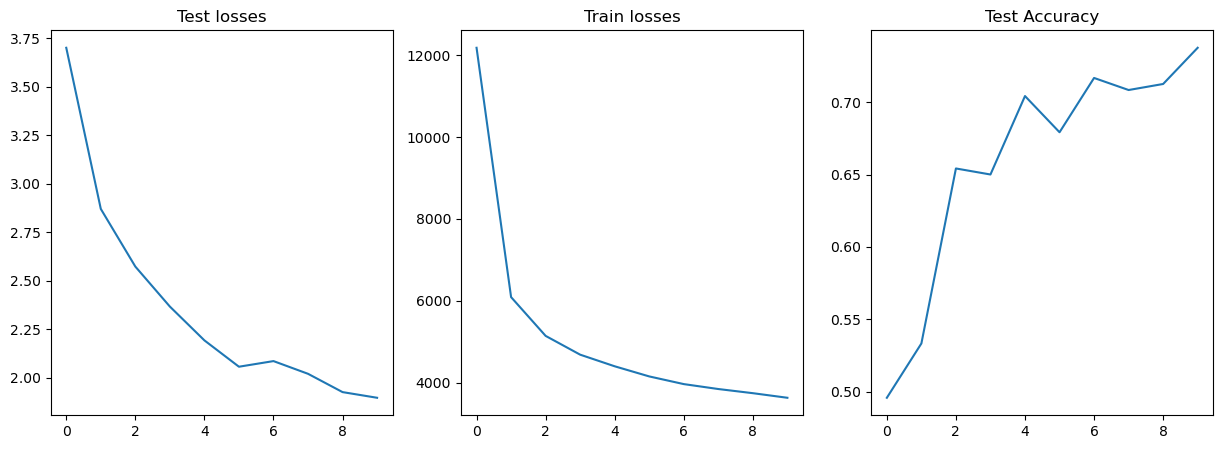


Validation batch:
loss 1.8225078582763672
acuracy: 0.70833
train batch: epoch 10 - loss 3550.790854968295


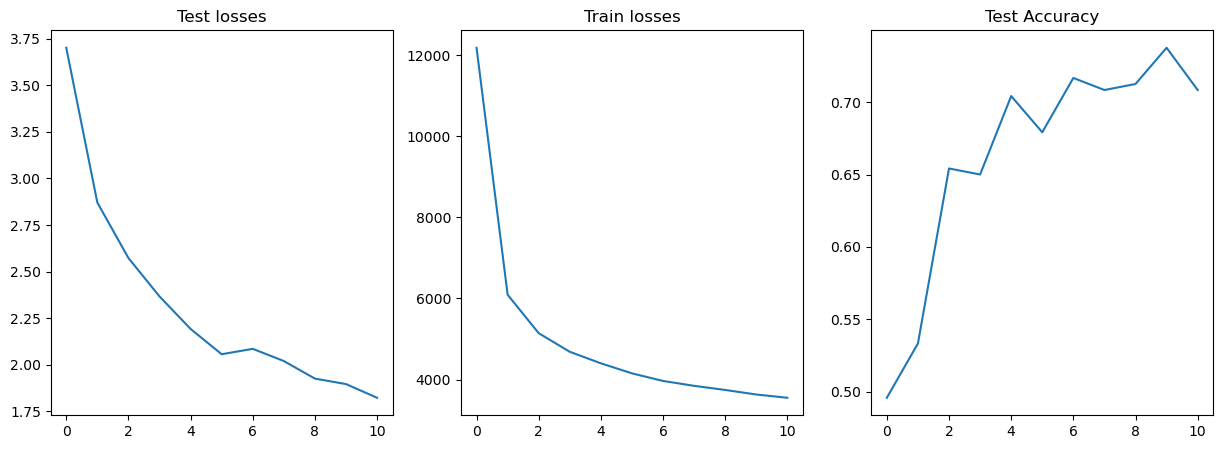


Validation batch:
loss 1.821914792060852
acuracy: 0.73333
train batch: epoch 11 - loss 3437.1967556116488


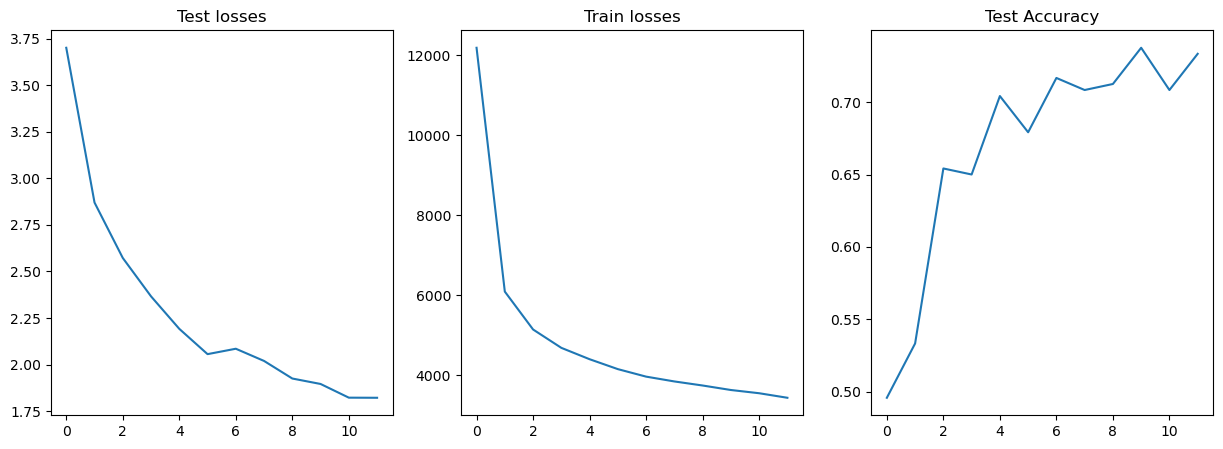


Validation batch:
loss 1.7686331272125244
acuracy: 0.71667
train batch: epoch 12 - loss 3365.4566706748315


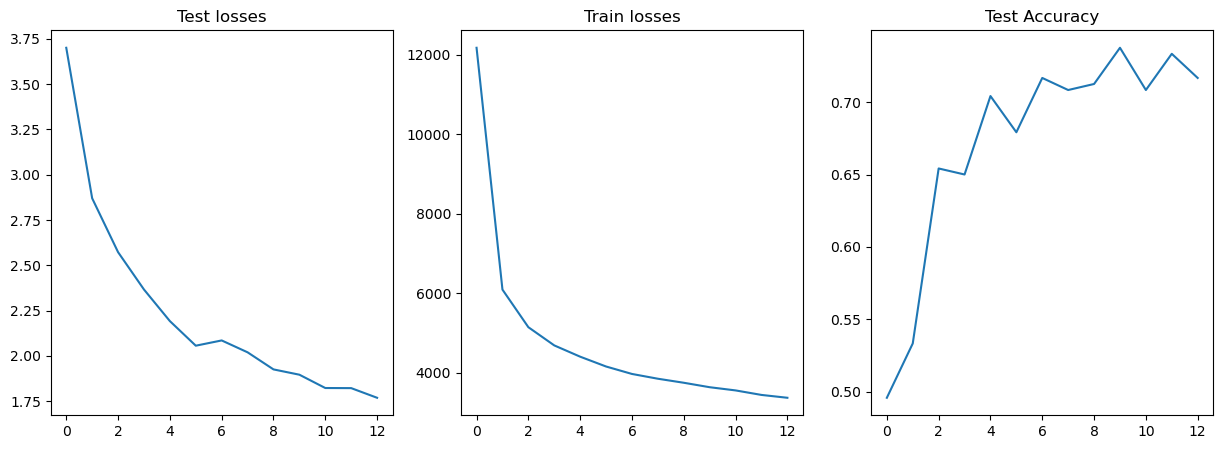


Validation batch:
loss 1.7666743993759155
acuracy: 0.72500
train batch: epoch 13 - loss 3299.995433569853


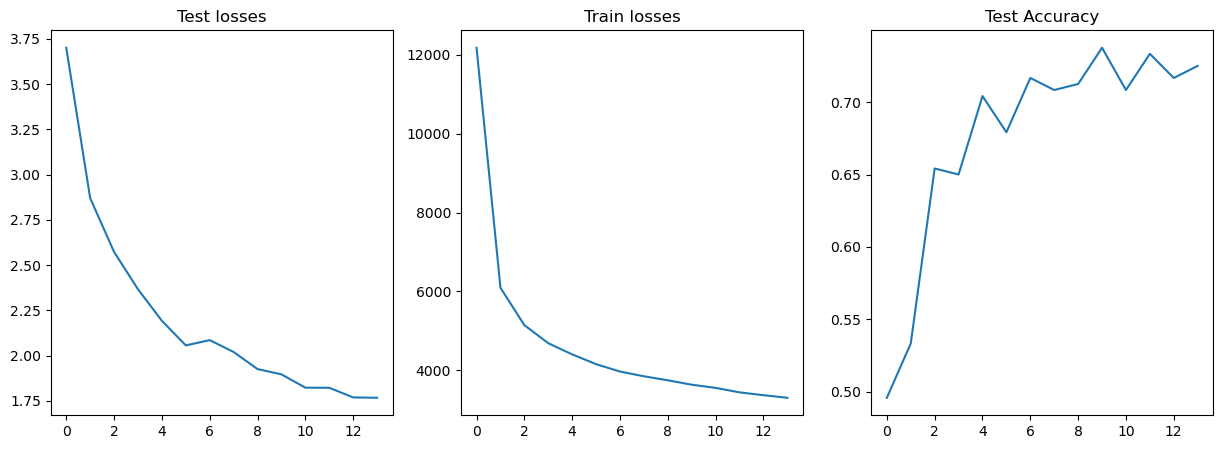

In [ ]:
metas = []
bests = []
for i in range(5):
    meta_network = MetaNetwork(Detection.NUM_QUERIES)
    test_losses, test_acc, train_losses, best_model = train_MNTD(meta_network, train, validation_split=0.1)
    metas.append(meta_network.state_dict())
    bests.append(best_model)
    pickle_model("backup", f"meta_{i}",  meta_network)

In [ ]:
for meta in metas:
    net = MetaNetwork(Detection.NUM_QUERIES)
    net.load_state_dict(meta)
    test_MNTD(net, test)

loss 4.211414337158203
acuracy: 0.70459


(tensor(4.2114, grad_fn=<AddBackward0>), 0.7045889101338432)

In [ ]:
for best in bests:
    net = MetaNetwork(Detection.NUM_QUERIES)
    net.load_state_dict(best)
    test_MNTD(net, test)

query size (input): 11760
loss 4.251631736755371
acuracy: 0.69981


(tensor(4.2516, grad_fn=<AddBackward0>), 0.6998087954110899)